# Developing FEM in 2D

In [2]:

%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [19]:
#Interactive 3d plot. also need `pip3 install ipympl`
%matplotlib widget





-----

In the first part of this note, we look at constructing a finite element approximation to
$$
\begin{align*}
{}- \nabla\cdot \kappa(x,y) \nabla &u = f(x,y)\qquad((x,y)\in\Omega),\\
u &= g(x,y)\qquad ((x,y)\in \partial \Omega).
\end{align*}
$$
We define $\kappa$, $f$, and $g$ in a bit.

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

## Mesh the Domain

This uses [meshpy](https://documen.tician.de/meshpy/), which under the hood uses [Triangle](https://www.cs.cmu.edu/~quake/triangle.html).

`pip install meshpy` to install.

NB: Triangle is *not* open-source software. If you are looking for a quality mesher that is open-source (but a bit more complex to use), look at [Gmsh](http://gmsh.info/).

In [3]:
import meshpy.triangle as triangle

def round_trip_connect(start, end):
    return [(i, i+1) for i in range(start, end)] + [(end, start)]

def make_mesh():
    points = [(-1, -1), (1, -1), (1, 1), (-1, 1)]
    facets = round_trip_connect(0, len(points)-1)

    circ_start = len(points)
    points.extend(
            (0.25 * np.cos(angle), 0.25 * np.sin(angle))
            for angle in np.linspace(0, 2*np.pi, 30, endpoint=False))

    facets.extend(round_trip_connect(circ_start, len(points)-1))

    def needs_refinement(vertices, area):
        bary = np.sum(np.array(vertices), axis=0)/3
        max_area = 0.01 + la.norm(bary, np.inf)*0.01
        return bool(area > max_area)

    info = triangle.MeshInfo()
    info.set_points(points)
    info.set_facets(facets)

    built_mesh = triangle.build(info, refinement_func=needs_refinement)
    return np.array(built_mesh.points), np.array(built_mesh.elements)

V, E = make_mesh()

In [23]:
nv = len(V)
ne = len(E)
print(V.shape) # 239 vertices, each denoted by cordinates (x,y)
print(E.shape) # 441 elements(triangles), each denoted by (v1,v2,v3)
print(E.max())


(236, 2)
(436, 3)
235


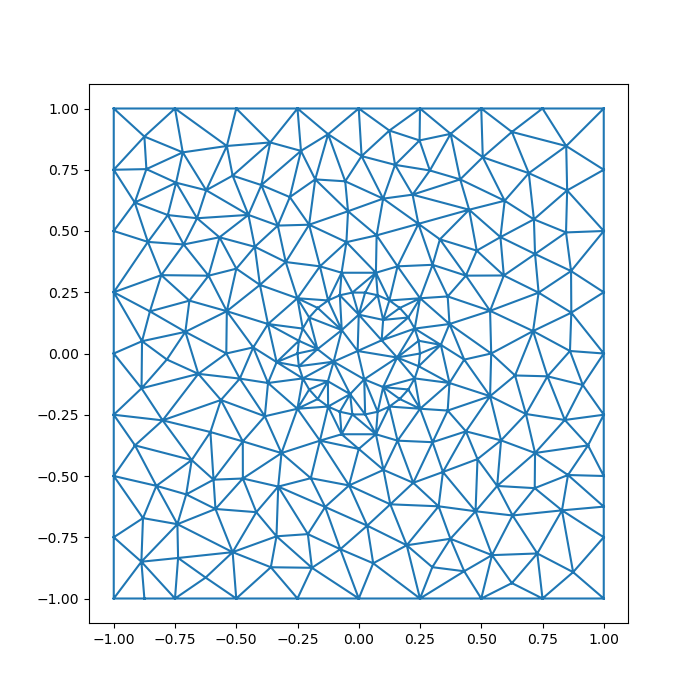

In [24]:
#visualize grids
X, Y = V[:, 0], V[:, 1]
plt.figure(figsize=(7,7))
plt.gca().set_aspect("equal")
plt.triplot(X, Y, E)

## Local Basis functions
We choose 1-order-polynomials in the triangle. 
<div>
<img src="./figs/fig1.png" width="400"/> <img src="./figs/fig2.png" width="300"/>
</div>

## Constructing Element Mappings

Map the reference triangle [(0,0), (0,1), (1,0)] to any element triangle given by vertices [v1,v2,v3]:

In [25]:
v1 = np.array([1.0, 1.0])
v2 = np.array([3.0, 1.0])
v3 = np.array([2.0, 2.0])

Come up with the matrix `TA` and vector `Tb` of the affine mapping, such that reference triangle is mapped to the element triangle.

In [26]:
TA = np.array([v2-v1, v3-v1]).T
Tb = v1

Test the mapping.

In [27]:
# make random points in the reference triangle
r = np.random.rand(1000, 2)
r = r[r[:, 0]+r[:, 1] < 1]

x = np.einsum("ij,pj->pi", TA, r) + Tb

plt.plot(x[:, 0], x[:, 1], "o")
plt.plot(r[:, 0], r[:, 1], "o")
plt.plot(v1[0], v1[1], "o", label="v1")
plt.plot(v2[0], v2[1], "o", label="v2")
plt.plot(v3[0], v3[1], "o", label="v3")
plt.legend()

The figure above shows that reference element $\hat E$ (orange) is indeed mapped to the element $E$ (blue) by linear transformation $T$. 

For notation consistency, in the notes below we denote the 'reference' element and basis by the hat symbol '$\hat{} $'. E.g. the basis functions in referemce element are denoted by $\hat{\varphi}_{1,2,3}$

## Derive Linear Systems 

### Weak form 
Suppose that the PDE is (temporally let BC be zero):
$$
\begin{align}
{}- \nabla\cdot \kappa(x,y) \nabla u(x,y) &= f(x,y)\qquad((x,y)\in\Omega),\\
u(x,y) &= 0\qquad \qquad ((x,y)\in \partial \Omega).
\end{align}
$$
The weak form is to multiply the PDE by a test function $v \in H_0^1(\Omega)$, then integral on $\Omega$. The resulting equation is mathematically 'weaker' than the original PDE, since it is 1) an integral instead of point-wise, and 2)multiplied by test functions. 
$$
\begin{align}
\label{eq:weak-form}
\int_{\Omega}[-\nabla \cdot(\kappa(\boldsymbol{x}) \nabla u)-f(\boldsymbol{x})] v \mathrm{~d} \boldsymbol{x}=0  \quad \text{(for every test func $v \in H_0^1(\Omega)$)}\\
\end{align}
$$


Optionally, we can integrate by parts to simplify the above equation:
$$
\begin{align}
\Leftrightarrow-\int_{\partial \Omega} v[\kappa \widehat{\boldsymbol{n}} \cdot \nabla u] \mathrm{d} \Gamma+\int_{\Omega}[\kappa(\boldsymbol{x}) \nabla u \cdot \nabla v-f(\boldsymbol{x}) v] \mathrm{d} \boldsymbol{x}=0 .
\end{align}
$$

...But get a more complex one? Note that the subscript $0$ in test function space $H_0^1(\Omega)$ means that test function $v$ has compact support $\Omega$, i.e. $v$ is zero at the boundary $\partial \Omega$ and outside of $\Omega$. Thus, the first term in the above equation is zero:
$$
\begin{align}
\label{eq:int-by-part-weak-form}
\Leftrightarrow \int_{\Omega}[\kappa(\boldsymbol{x}) \nabla u \cdot \nabla v-f(\boldsymbol{x}) v] \mathrm{d} \boldsymbol{x}=0 .
\end{align}
$$
Compared with Eq.\ref{eq:weak-form}, the 2-order-derivative of $u$ is now simplified to 1-order, while the 0-order-derivative $v$ is now increased to 1-order, which is usually simple.

Notice that if we move $\int f(x)v$ to the right side, then the above equation can be regarded as **bilinear form**:
$$
a(u,v) = b(v),
$$
where a is linear w.r.t. both $u,v$ (thus 'bilinear'), and $b$ is linear w.r.t. $v$.  We are going to discretize it as a linear system $Ac=b$, by defining elements and basis functions.

### Split Domain into Elements, and Define Basis for $u$
We already implemented these steps. Split the domain $\Omega$ into many elements $E$, the triangles in our case. And each element can be obtained by linear transform $T$ on reference element $\hat E$. As for basis functions, we choose the linear basis $\varphi$ as previously visualized. The basis functions $\varphi_i, \varphi_{i+1}, \varphi_{i+2}$ can similarly calculated from $\hat \varphi_1, \hat \varphi_{2}, \hat \varphi_{3}$. Then on the $i$-th element $E$, the Eq.\ref{eq:int-by-part-weak-form} becomes:
$$
\begin{align}
\int_{E}[\kappa(\boldsymbol{x}) \nabla (c_i\varphi_i + c_{i+1} \varphi_{i+1}+ c_{i+2}\varphi_{i+2}) \cdot \nabla v-f(\boldsymbol{x}) v] \mathrm{d} \boldsymbol{x}=0, \quad \text{(for every test func $v$)}
\end{align}
$$
where $\Omega$ is replaced $E$, and $u$ is replaed by $(c_i\varphi_i + c_{i+1} \varphi_{i+1}+ c_{i+2}\varphi_{i+2})$, and $c_{i, i+1, i+2}$ are unknown coefficients (called degree-of-freedom, DOF) to be solved.


Since the first term is **linear w.r.t. $u$**, we can extract coefficients out (and move $f$ to right):
$$
\begin{align}
\sum_{j = i}^{i+2} c_j \int_{E}\kappa(\boldsymbol{x}) \nabla \varphi_j \cdot \nabla v \mathrm{d} \boldsymbol{x}=   \int_{E}f(\boldsymbol{x}) v \mathrm{d} \boldsymbol{x}, \quad \text{(for every test func $v$)}
\end{align}
$$
When the first term is non-linear, we need to approximate it by a series of linear equations (later).


### Define Basis for $v$: Galerkin Method
The basis functions $\{\varphi_i\}$ are initially designed for approximate solution $u$, but the Galerkin method proposes to **use the same basis also for test function** $v$ (except at the boundary). For the $i$-th element $E$, let $v \in \operatorname{span}\{\varphi_i, \varphi_{i+1}, \varphi_{i+2} \}$. Since $v$ is always linear w.r.t. the weak form expression, we only need to check three test functions $v=\varphi_i, \varphi_{i+1}, \varphi_{i+2}$, instead of exhausting the whole test function space.
$$
\begin{align}
\sum_{j = i}^{i+2} c_j \int_{E}\kappa(\boldsymbol{x}) \nabla \varphi_j \cdot \nabla v \mathrm{d} \boldsymbol{x}=   \int_{E}f(\boldsymbol{x}) v \mathrm{d} \boldsymbol{x}, \quad \text{(for test func $v=\varphi_i, \varphi_{i+1}, \varphi_{i+2}$)}
\end{align}
$$

### Rewrite as Linear System
Now for each element, we have 3 unknowns $c_{i, i+1, i+2}$, and 3 equations induced by $v=\varphi_{i,i+1,i+2}$. Thus the weak form on the $i$-th element can be rewritten as a 3-dim linear system:
$$
\begin{equation}
\left[\begin{array}{ccc}
\int_{E}\kappa(\boldsymbol{x}) \nabla \varphi_i \cdot \nabla \varphi_{i} \mathrm{d} \boldsymbol{x} & 
\int_{E}\kappa(\boldsymbol{x}) \nabla \varphi_{i+1} \cdot \nabla \varphi_{i} \mathrm{d} \boldsymbol{x} &
\int_{E}\kappa(\boldsymbol{x}) \nabla \varphi_{i+2} \cdot \nabla \varphi_{i} \mathrm{d} \boldsymbol{x} \\
\int_{E}\kappa(\boldsymbol{x}) \nabla \varphi_i \cdot \nabla \varphi_{i+1} \mathrm{d} \boldsymbol{x} & 
\int_{E}\kappa(\boldsymbol{x}) \nabla \varphi_{i+1} \cdot \nabla \varphi_{i+1} \mathrm{d} \boldsymbol{x} &
\int_{E}\kappa(\boldsymbol{x}) \nabla \varphi_{i+2} \cdot \nabla \varphi_{i+1} \mathrm{d} \boldsymbol{x} \\
\int_{E}\kappa(\boldsymbol{x}) \nabla \varphi_i \cdot \nabla \varphi_{i+2} \mathrm{d} \boldsymbol{x} & 
\int_{E}\kappa(\boldsymbol{x}) \nabla \varphi_{i+1} \cdot \nabla \varphi_{i+2} \mathrm{d} \boldsymbol{x} &
\int_{E}\kappa(\boldsymbol{x}) \nabla \varphi_{i+2} \cdot \nabla \varphi_{i+2} \mathrm{d} \boldsymbol{x} \\
\end{array}\right]
\left[\begin{array}{c}c_{i} \\ c_{i+1} \\ c_{i+2}
\end{array}\right]
=\left[\begin{array}{c}
\int_{E}f(\boldsymbol{x}) \varphi_{i} \mathrm{d} \boldsymbol{x} \\ 
\int_{E}f(\boldsymbol{x}) \varphi_{i+1} \mathrm{d} \boldsymbol{x} \\ 
\int_{E}f(\boldsymbol{x}) \varphi_{i+2} \mathrm{d} \boldsymbol{x} \\ 
\end{array}\right]
\end{equation}
$$


### Assemble Local Systems into a Global System

The local and dense systems from all elements are assembled into a global but sparse system $Ac=b$. Each row is an equation induced by a basis of test function $v$, each column is a basis of the trial function $u$. Galerkin method uses the same basis for $v$ and $u$, thus \#row = \#col, i.e. num of equations equals the num of unknowns.

Remark that there must be many 'repeated' equations from different local systems, since there are many nodes(test funcs) occupied by more than two elements.  Those repeated equations are **summed** in the assembly of $A$ and $b$. There might be cases where the summed global system $Ac=b$ is satisfied but the local systems are not, since the positive and negative residuals cancel out after summation. That is, the FEM solves **weak-form in the global sense**, not the element-wise sense. The summation can be interpreted as $\int_\Omega = \sum_{E_i} \int_{E_i}$.

A [demo](https://caendkoelsch.wordpress.com/2017/12/03/how-are-stiffness-matrices-assembled-in-fem/) for assembly of stiffness matrix $A$.

## Details of Calculation

### LHS Integral 
Each entry of the LHS matrix is an integral $\int_E \kappa(\boldsymbol{x}) \nabla_{\boldsymbol{x}} \varphi_i(\boldsymbol{x})^T \nabla_{\boldsymbol{x}} \varphi_j(\boldsymbol{x}) d \boldsymbol{x}$ over $E$. For ease of computation, we transform it to an integral on reference element $\hat E$ by changing the variable from $x$ to $r$. Calculations are derived step by step:

1. define transformation $T:\hat E \rightarrow E$ and its Jaccobi $J_T$:
$$
T(r, s)=\left(\boldsymbol{x}_2-\boldsymbol{x}_1\right) r+\left(\boldsymbol{x}_3-\boldsymbol{x}_1\right) s+\boldsymbol{x}_1
$$
$$
\begin{aligned}
J_T & =\left[\begin{array}{ll}
\partial x / \partial r & \partial x / \partial s \\
\partial y / \partial r & \partial y / \partial s
\end{array}\right]=\left[\begin{array}{ll}
\frac{\partial T}{\partial r} & \frac{\partial T}{\partial s}
\end{array}\right] \\
& =\left[\begin{array}{ll}
\left(\boldsymbol{x}_2-\boldsymbol{x}_1\right) & \left(\boldsymbol{x}_3-\boldsymbol{x}_1\right)
\end{array}\right] \in \mathbb{R}^{2 \times 2} .
\end{aligned}
$$

2. Change $x$-gradient on $i$-th element's basis funcs $\nabla_x \varphi_{j=i,i+1,i+2}$ to $r$-gradient on reference element's basis funcs $\nabla_r \hat \varphi_{j=1,2,3}$. (Change-of-variable rule for gradient)

$$
\begin{aligned}
\nabla_{\boldsymbol{x}} \varphi_j\left(\boldsymbol{x}\right) &=
\nabla_{\boldsymbol{x}} \hat \varphi_j\left(T^{-1}(\boldsymbol{x})\right) & \text{def of T} \\
& =\left[\frac{d}{d \boldsymbol{x}} \hat \varphi_j\left(T^{-1}(\boldsymbol{x})\right)\right]^T  & \text{def of gradient and derivative} \\
& =\left[\left(\frac{d \hat \varphi_j (\boldsymbol{r})}{d \boldsymbol{r}}\right)_{\boldsymbol{r}=T^{-1}(\boldsymbol{x})} \frac{d T^{-1}(\boldsymbol{x}) }{d \boldsymbol{x}} \right]^T  & \text{chain rule}\\
&= \left[\nabla_{\boldsymbol{r}} \hat  \varphi_j\left(T^{-1}(\boldsymbol{x})\right)^T J_T^{-1}(\boldsymbol{x}) \right]^T  & \text{def of gradient and jaccobi} \\
& =J_T^{-T}(\boldsymbol{x}) \nabla_{\boldsymbol{r}} \hat  \varphi_j\left(T^{-1}(\boldsymbol{x})\right) . 
\end{aligned}
$$



3. Numerically evaluate the integral

$$
\begin{aligned}
& \int_E \kappa(\boldsymbol{x}) \nabla_{\boldsymbol{x}} \varphi_i(\boldsymbol{x})^T \nabla_{\boldsymbol{x}} \varphi_j(\boldsymbol{x}) d \boldsymbol{x} \\
= & \int_E \kappa(\boldsymbol{x})\left(J_T^{-T} \nabla_{\boldsymbol{r}} \hat \varphi_i(T^{-1}(\boldsymbol{x})) \right)^T\left(J_T^{-T} \nabla_{\boldsymbol{r}} \hat \varphi_j(T^{-1}(\boldsymbol{x}))\right) d \boldsymbol{x}  & \text{by Step 2}\\
\stackrel{P 1}{=} & \left(J_T^{-T} \nabla_{\boldsymbol{r}} \varphi_i\right)^T\left(J_T^{-T} \nabla_{\boldsymbol{r}} \varphi_j\right) \int_{E} \kappa(x) d \boldsymbol{x}  & \text{$\hat \varphi$ =1-order-Poly, $\nabla \hat \varphi$ = const} \\
=  & \left(J_T^{-T} \nabla_{\boldsymbol{r}} \varphi_i\right)^T\left(J_T^{-T} \nabla_{\boldsymbol{r}} \varphi_j\right)\left|J_T\right| \int_{\hat{E}} \kappa(T(\boldsymbol{r})) d \boldsymbol{r} & \text{change of variable on integral} \\
\approx & \left(J_T^{-T} \nabla_{\boldsymbol{r}} \varphi_i\right)^T\left(J_T^{-T} \nabla_{\boldsymbol{r}} \varphi_j\right)\left|J_T\right| \kappa(T(\bar{\boldsymbol{r}}))/2.  &\text{1-point Gauss Quadrature rule}
\end{aligned}
$$

$\bar{\boldsymbol{r}}$ is the centroid of the reference element, $[1/3,1/3]$ in our case. Gauss Quadrature rule is a numerical approximation for integral. 1-point Gauss Quadrature is accurate only if integrand $\kappa \circ T$ is well-approximated by 1-order-polynomials.

4. (Extension) For general PDE, the LHS may look like $\lambda uv + \kappa \nabla v \cdot  \nabla u$. We can similarly compute the integral for the $\lambda uv$ term by 1-point Gauss Quadrature:
$$
\begin{aligned}
& \int_E \lambda(\boldsymbol{x}) \varphi_i(\boldsymbol{x})\varphi_j(\boldsymbol{x}) d \boldsymbol{x} \\
=& |J_T| \int_{\hat{E}} \varphi_i(T(\boldsymbol{r})) \varphi_j(T(\boldsymbol{r})) \lambda(T(\boldsymbol{r})) d \boldsymbol{r} & \text{change of variable on integral}. \\
=& \left|J_T\right| \varphi_i(T(\bar{\boldsymbol{r}}))\varphi_j(T(\bar{\boldsymbol{r}})) \lambda(T(\bar{\boldsymbol{r}}))/2.  &\text{1-point Gauss Quadrature rule} \\
=& \left|J_T\right| \lambda(T(\bar{\boldsymbol{r}}))/18.  &\varphi(\bar{x})=1/3
\end{aligned}
$$

### RHS Integral
RHS is similar and simple:

$$
\begin{aligned}
\int_E f(\boldsymbol{x}) \varphi_i(\boldsymbol{x}) d \boldsymbol{x} &= \left|J_T\right| \int_{\hat{E}} f(T(\boldsymbol{r})) \hat \varphi_i(\boldsymbol{r}) d \boldsymbol{r} \\
& \approx \frac{1}{2} \left|J_T\right|  f(T(\bar{\boldsymbol{r}})) \hat \varphi_i(\bar{\boldsymbol{r}})   & \text{1-point Gauss Quadrature rule} \\
& = \frac{1}{6} \left|J_T\right|  f(T(\bar{\boldsymbol{r}})) & \text{$\bar{\boldsymbol{r}}=[1/3,1/3], \hat \varphi_i(\bar{\boldsymbol{r}})=1/3$} 
\end{aligned}
$$
Accurate only of $f \circ T()\hat \varphi_i()$ is well-approximated by 1-order-polynomials, i.e. $f \circ T$ is constant.





---
## Coding for $A$ and $b$

## Problem Data
Define $\kappa$, $f$, and $g$.

In [11]:
def kappa(xvec):  #left-hand-side(lhs) non-linear func 
    x, y = xvec
    if (x**2 + y**2)**0.5 <= 0.25:
        return 25.0
    else:
        return 1.0

def f(xvec):    #rhs func
    x, y = xvec
    if (x**2 + y**2)**0.5 <= 0.25:
        return 100.0
    else:
        return 0.0

    
def g(xvec):  #boundary condition
    x, y = xvec
    return 1 * (1 - x**2) 

### Sparse Matrix Helper

In [12]:

class MatrixBuilder:  #sparse matrix helper 
    def __init__(self):
        self.rows = []
        self.cols = []
        self.vals = []
        
    def add(self, rows, cols, submat):
        for i, ri in enumerate(rows):
            for j, cj in enumerate(cols):
                self.rows.append(ri)
                self.cols.append(cj)
                self.vals.append(submat[i, j])
                
    def coo_matrix(self):
        return sparse.coo_matrix((self.vals, (self.rows, self.cols)))

Recall the nodal linear basis $\hat \varphi_{1,2,3}$ on reference element $\hat E = \{(r,s)| 0 \le r+s \le 1\}$:
- $\hat \varphi_1(r,s) =1-r-s$
- $\hat \varphi_2(r,s) =r$
- $\hat \varphi_3(r,s) =s$

Create a $2\times N_p$ array containing $\nabla_{\boldsymbol r} \varphi_i$, where $N_p$ is num of basises, here 3.

In [13]:
# derivative of basis function verphi_{1,2,3}
dbasis = np.array([
    [-1, 1, 0],  # dphi/dr
    [-1, 0, 1]]) # dphi/ds

 ### LHS

In [28]:
#Assemble the matrix (LHS). Use a `MatrixBuilder` `a_builder`. 
a_builder = MatrixBuilder()

for ei in range(0, ne):
    vert_indices = E[ei, :]
    x0, x1, x2 = el_verts = V[vert_indices]
    centroid = np.mean(el_verts, axis=0)

    J = np.array([x1-x0, x2-x0]).T
    invJT = la.inv(J.T)
    detJ = la.det(J)
    dphi = invJT @ dbasis

    Aelem = kappa(centroid) * (detJ / 2.0) * dphi.T @ dphi

    a_builder.add(vert_indices, vert_indices, Aelem)

In [29]:
idx = list(zip(a_builder.rows, a_builder.cols))
seen = set()
dupes = [x for x in idx if x in seen or seen.add(x)] 
print(len(idx))
print(len(dupes)) #Many duplicate entries

3924
2346


Eliminate duplicate entries in the COO-form sparse matrix:

In [30]:
A = a_builder.coo_matrix().tocsr().tocoo() #Duplicate entries will be summed together

### RHS 

In [31]:
#clear
b = np.zeros(nv)

for ei in range(0, ne):
    vert_indices = E[ei, :]
    x0, x1, x2 = el_verts = V[vert_indices]
    centroid = np.mean(el_verts, axis=0)

    J = np.array([x1-x0, x2-x0]).T
    detJ = la.det(J)

    belem = f(centroid) * (detJ / 6.0) * np.ones((3,))

    for i, vi in enumerate(vert_indices):
        b[vi] += belem[i]

---
### Boundary Conditions
Up to now, we have already formulated the homogeneous (zero boundaries) PDE as a bilinear-form $a(u,v) = b(v)$, and further discretize it as a linear system $Ac=b$. To force the zero boundaries, we need to force the $c$ to be zero at the boundary. Thus, the rows of $A_i$ involves boundary node $i$ is replaced by a one-hot vector $\mathbb{1}_i$, and the $b_i$ is set to zero. I.e. $A_i c= b_i$ becomes $\mathbb{1}_i c = 0$.

Notice that The original equation $A_i c= b_i$ should be discarded at the boundary node $i$. The equation is induced by the weak form with test function $\varphi_i$. Observe that $\varphi_i$ should be zero at the boundary since it is in $H_0^1$. Further more,  $\varphi_i$ should be zero in the whole element since it is 1-order-polynomial. Thus, for such constant zero $\varphi_i$, the weak form degenerates to $0=0$. That is why the $A_i c= b_i$ should be replaced by the $\mathbb{1}_i c = 0$.


Next, we will consider inhomogeneous (non-zero boundary $u(x)=g(x), x \in \partial \Omega$), and show that it is still reduced to a bilinear form and can be converted to a linear system.

Define a function $u^0 \in H^1(\Omega)$ such that $u^0(x):=g(x) \text{ if } x \in \partial \Omega; u^0(x):=0 \text{ otherwise}$.
Define the solution as $u$, and auxiliary solution as $\hat{u}:=u-u^0 \in H^1_0(\Omega)$. Then the weak form $a(u,v) = b(v)$ (bilinear w.r.t. $u,v$) can be written as bilinear form $a(\hat u,v)= \hat b(v)$ w.r.t. $\hat u, v$:

$$
\begin{aligned}
   a(u,v) &= b(v) \\
\Rightarrow  a(\hat u + u^0,v) &= b(v) \\
\Rightarrow  a(\hat u,v) + a(u^0,v) &= b(v)  &\text{linearity of $a$}\\
\Rightarrow  a(\hat u,v) &= \underbrace{b(v) - a(u^0,v)}_{\hat b(v):= } 
\end{aligned}
$$
The BC only adds an extra term $a(u^0,v)$ on RHS. The new system is a zero-boundary system w.r.t. $\hat u$. One can similarly construct and solve the linear system $A\hat c=\hat b$ to obtain $\hat u$, and then reconstruct the final result $u= \hat u + u^0$.

The extra term $a(u^0,v)$ is computed as $Ac^0$, where $c^0$ is basis func coefficients of $u^0$, obtained by regession the boundary nodes with $g(x)$. 

### Coding for Boundary Conditions

Create flags for the boundary vertices/DoFs:

In [32]:
tol = 1e-12
is_boundary = (
    (np.abs(X+1) < tol)
    | (np.abs(X-1) < tol)
    | (np.abs(Y+1) < tol)
    | (np.abs(Y-1) < tol))

is_g_boundary = np.abs(Y+1) < tol

Next, construct the 'volume-lifted' boundary condition $u^0$.

In [33]:
#clear
u0 = np.zeros(nv)
u0[is_g_boundary] = g(V[is_g_boundary].T)

Compute the "post-lifting" right hand side `rhs`.

*Note:* The Riesz representer of `rhs` needs to be in $H^1_0$. (I.e. what should its values for the boundary DoFs be?)

In [34]:
#clear
rhs = b - A @ u0

rhs[is_boundary] = 0.0  #set b_i to zero

Next, set the rows corresponding to boundary DoFs to be $\mathbb{1}_i c= 0$, i.e. default zero:

In [35]:
#clear
for k in range(A.nnz): #nnz= number of non-zero elements.
    i = A.row[k]
    j = A.col[k]
    if is_boundary[i]:
        A.data[k] = 1 if i == j else 0  #set A[i,:] to one-hot $\mathbb{1}_i$.

## Solve and Plot

Now solve and correct for lifting:

In [36]:
#clear
uhat = sla.spsolve(A.tocsr(), rhs)

u = uhat + u0  #reconstruct solution u from \hat u and u_0

And plot:

/home/fengmingquan/anaconda3/envs/molecule/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


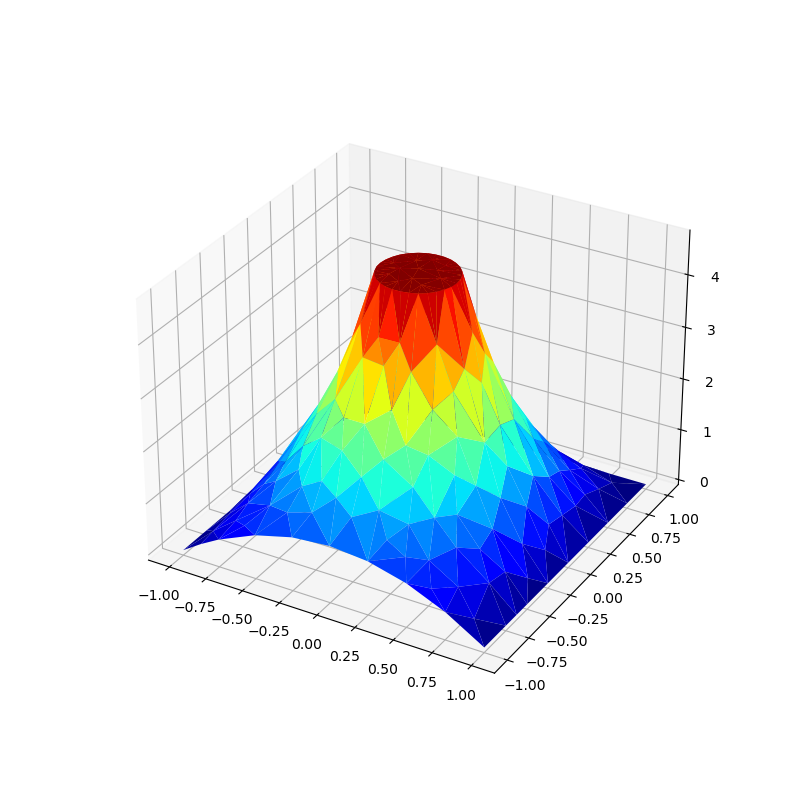

In [37]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca(projection='3d')
ax.plot_trisurf(X, Y, u, triangles=E, cmap=plt.cm.jet, linewidth=0.2)
plt.show()

### Another Test Case
We copy the codes above to the `femsolver.py` file, and define a solver named `FEMSolverV1`. Te test the correctness of this module, we generate anther test problem with exact solution.

In [4]:
from femsolver import FEMSolverV1
import sympy as sym
import numpy as np
x, y = sym.symbols('x y')
u = 1 + x**2 + y**2
kappa = sym.cos(x) + sym.sin(y)
f = - sym.diff(kappa*sym.diff(u, x), x) - sym.diff(kappa*sym.diff(u, y), y)
f = sym.simplify(f)
g = u
print('kappa=',kappa)
print("f=",f)
print("u_exact=", u)
kappa = sym.lambdify([(x, y)], kappa, 'numpy')
f = sym.lambdify([(x, y)], f, 'numpy')
g = sym.lambdify([(x, y)], g, 'numpy')
u_exact = sym.lambdify([(x, y)], u, 'numpy')


kappa= sin(y) + cos(x)
f= 2*x*sin(x) - 2*y*cos(y) - 4*sin(y) - 4*cos(x)
u_exact= x**2 + y**2 + 1


Notice that he kappa above is not 'well approximated by 1-order-Poly', thus the 1-point Gaussian quadrature rule is not accurate. But we can still get a relatively accurate result, since the kappa is approximiately close to P1 if the element is small enough.

Mean Abs Error= 0.014060827938729802


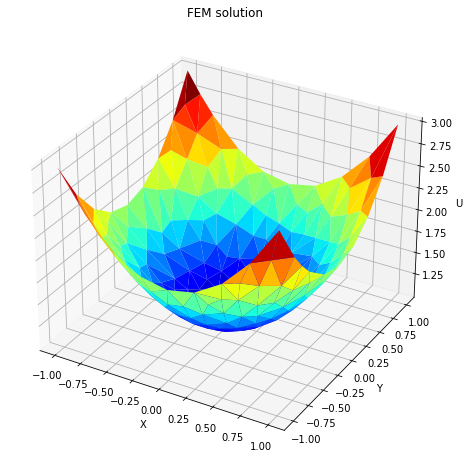

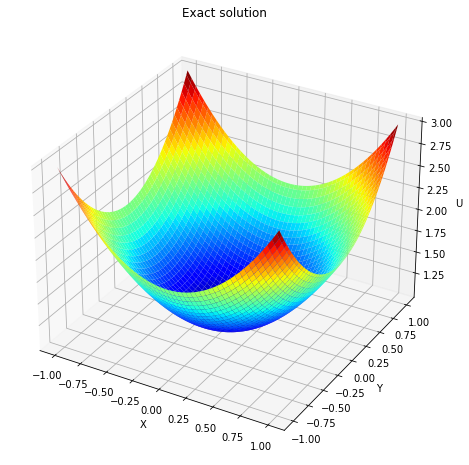

In [4]:
s = FEMSolverV1()
s.setDomain([(-1, -1), (1, -1), (1, 1), (-1, 1)], [(-1, -1), (1, -1), (1, 1), (-1, 1)])
sol = s.solve(kappa, f, g, u_exact=u_exact)

In [11]:
x, y = sym.symbols('x y')
u = 2 + x + 2*y
kappa = 1+ x - y
f = - sym.diff(kappa*sym.diff(u, x), x) - sym.diff(kappa*sym.diff(u, y), y)
f = sym.simplify(f)
g = u
print('kappa=',kappa)
print("f=",f)
print("g=",g)
print("u_exact=", u)
kappa = sym.lambdify([(x, y)], kappa, 'numpy')
f = sym.lambdify([(x, y)], f, 'numpy')
g = sym.lambdify([(x, y)], g, 'numpy')
u_exact = sym.lambdify([(x, y)], u, 'numpy')

kappa= x - y + 1
f= 1
g= x + 2*y + 2
u_exact= x + 2*y + 2


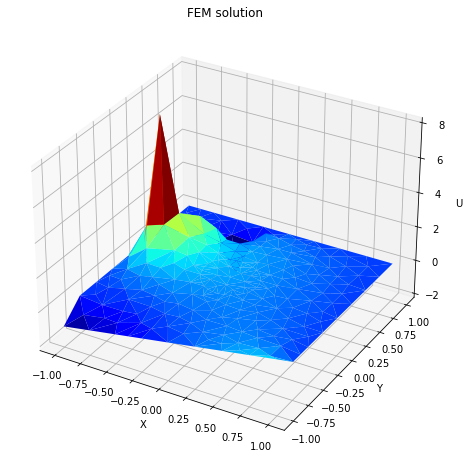

In [12]:
# A failed case: boundary conditions are insufficient.
s = FEMSolverV1()
s.setDomain([(-1, -1), (1, -1), (1, 1), (-1, 1)], [(-9999, -1)])
sol = s.solve(kappa, f, g)

In the above case, the boundary condition is only defined on y=-1, thus the other 3 sides of domain is the default zero boundary, which is not consistent with the exact solution. In other words, the problem is under-determined. We can add the boundary codntions to fix this problem. 

Mean Abs Error= 1.7792859199894373e-15


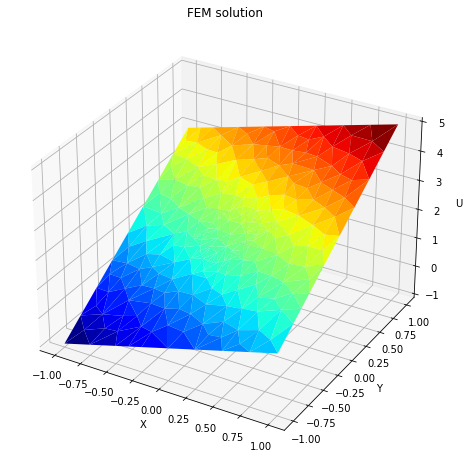

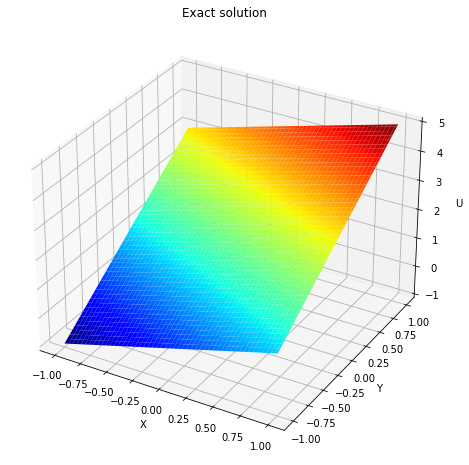

In [15]:
s.setDomain([(-1, -1), (1, -1), (1, 1), (-1, 1)], [(-1, -1), (1, -1), (1, 1), (-1, 1)])
sol = s.solve(kappa, f, g, u_exact=u_exact)

Another example, with non-zero lambda.

In [11]:
x, y = sym.symbols('x y')
u = 2 + sym.sin(x**2) + 2*y
kappa = 1+ x - y**3
lambda_ = y**2
f = lambda_* u - sym.diff(kappa*sym.diff(u, x), x) - sym.diff(kappa*sym.diff(u, y), y)
f = sym.simplify(f)
g = u
print('kappa=',kappa)
print('lambda=',lambda_)
print("f=",f)
print("g=",g)
print("u_exact=", u)
lambda_ = sym.lambdify([(x, y)], lambda_, 'numpy')
kappa = sym.lambdify([(x, y)], kappa, 'numpy')
f = sym.lambdify([(x, y)], f, 'numpy')
g = sym.lambdify([(x, y)], g, 'numpy')
u_exact = sym.lambdify([(x, y)], u, 'numpy')

kappa= x - y**3 + 1
lambda= y**2
f= 4*x**2*(x - y**3 + 1)*sin(x**2) - 2*x*cos(x**2) + y**2*(2*y + sin(x**2) + 2) + 6*y**2 + 2*(-x + y**3 - 1)*cos(x**2)
g= 2*y + sin(x**2) + 2
u_exact= 2*y + sin(x**2) + 2


Mean Abs Error= 0.006689723703318364


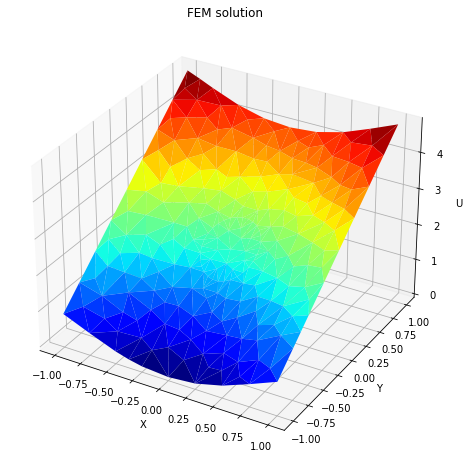

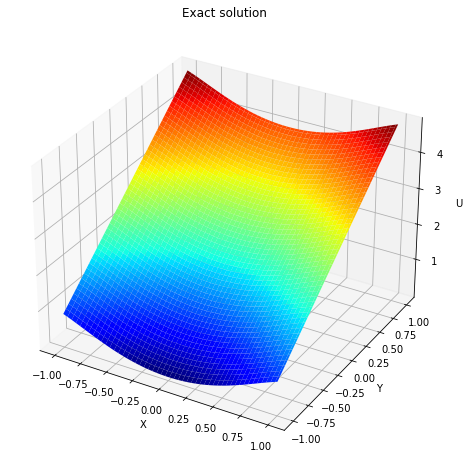

In [12]:
s = FEMSolverV1()
s.setDomain([(-1, -1), (1, -1), (1, 1), (-1, 1)], [(-1, -1), (1, -1), (1, 1), (-1, 1)])
sol = s.solve(kappa, f, g, lambda_=lambda_, u_exact=u_exact)

In summary, we have solved the basic poisson equation by FEM in this note. In the next note, we will explore the non-linear poisson equation.